In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
sys.path.insert(0,'src')

In [2]:
dir = 'models'
os.listdir(dir)

['wflc_small_snr0.5_200_aug10_losses.npy',
 'wflc_small_snr0_1000_losses.npy',
 'wflc_small_snr1000_200_aug10_losses.npy',
 'wflc_small_snr1000_2_aug10_best.npz',
 'wflc_small_snr1000_2_aug10_last.npz',
 'wflc_small_snr1000_2_aug10_losses.npy',
 'wflc_small_snr10_200_aug10_losses.npy',
 'wflc_small_snr1_500_aug10_losses.npy',
 'wflc_small_snr2_500_aug10_losses.npy',
 'wflc_small_snr5_200_aug10_losses.npy',
 'wflc_tiny_snr1_500_aug10_best.npz']

wflc_small_snr0.5_200_aug10_losses.npy
wflc_small 0.5


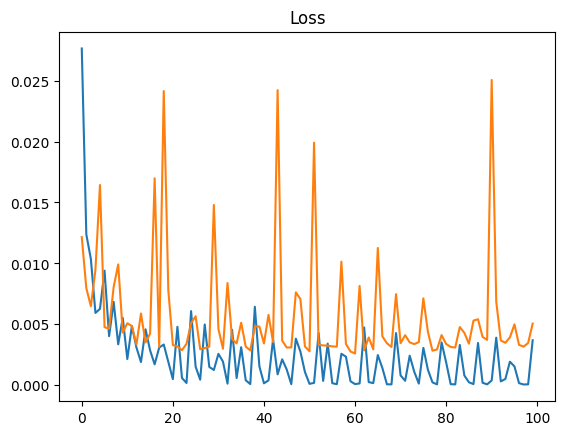

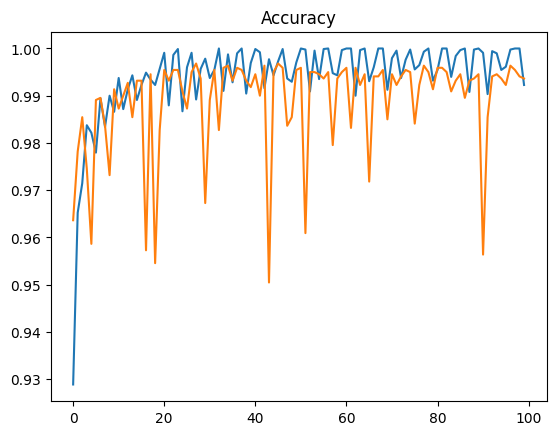

wflc_small_snr0_1000_losses.npy
wflc_small 0


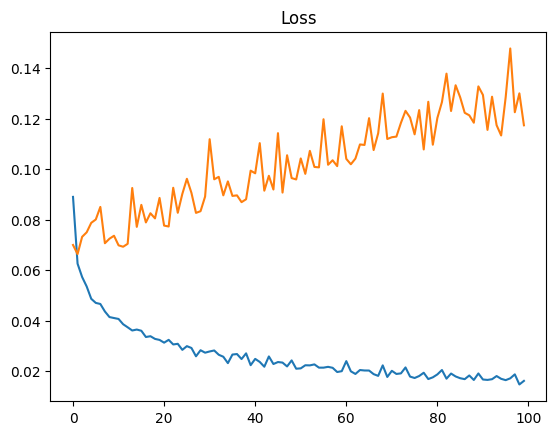

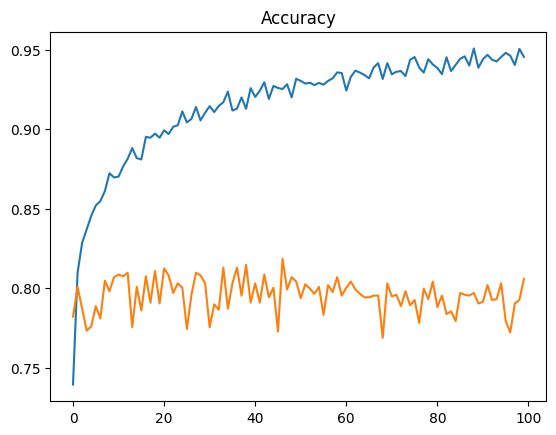

wflc_small_snr1000_200_aug10_losses.npy
wflc_small 1000


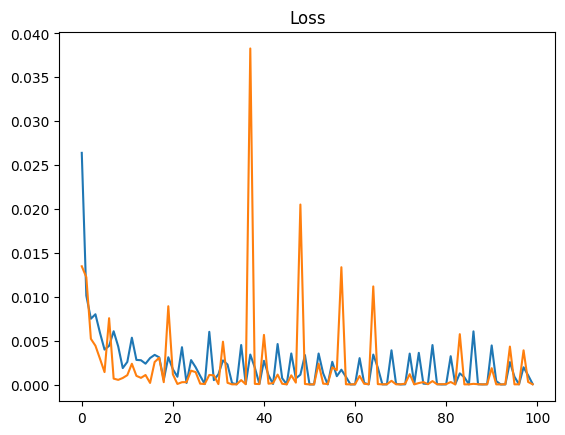

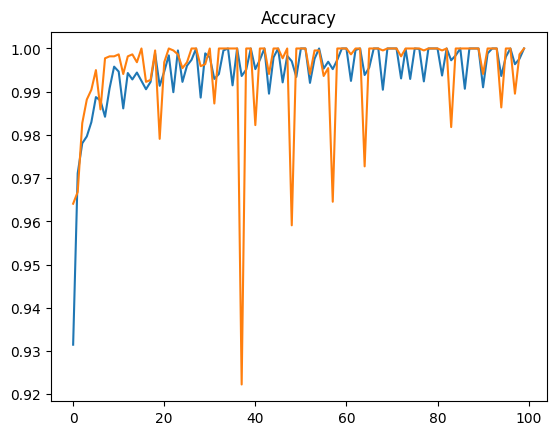

wflc_small_snr1000_2_aug10_losses.npy
wflc_small 1000


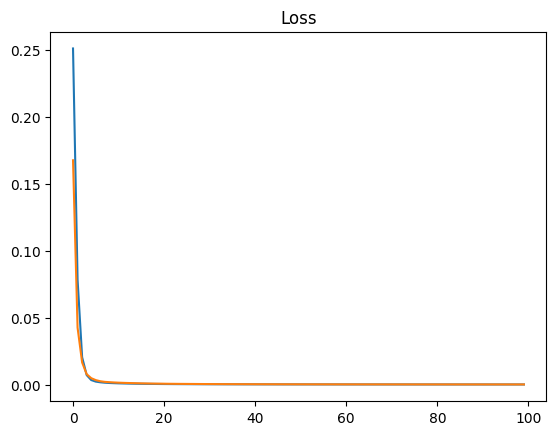

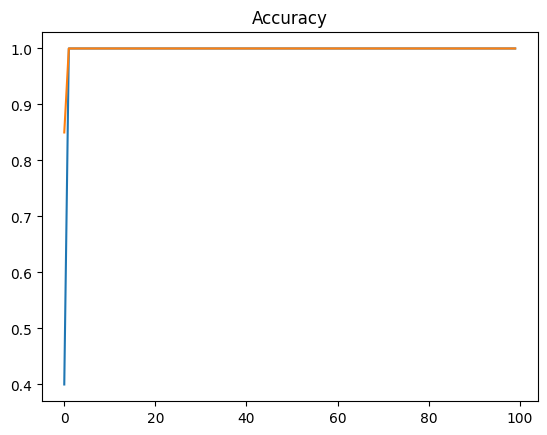

wflc_small_snr10_200_aug10_losses.npy
wflc_small 10


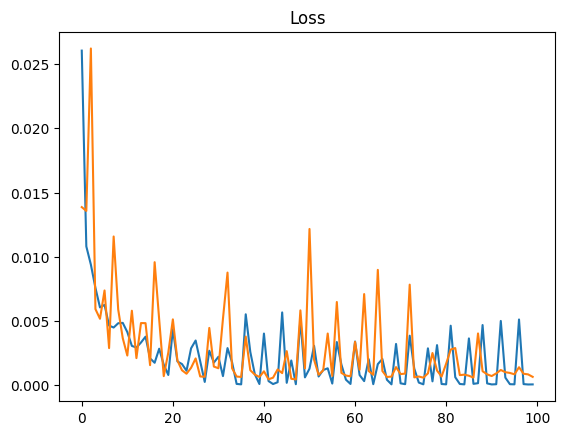

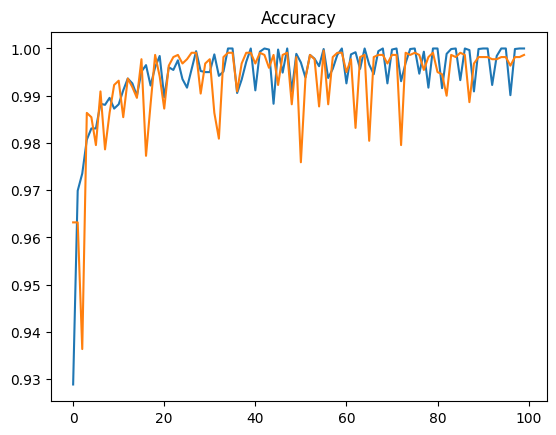

wflc_small_snr1_500_aug10_losses.npy
wflc_small 1


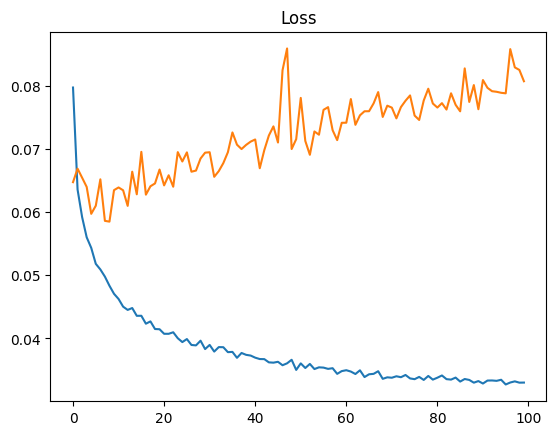

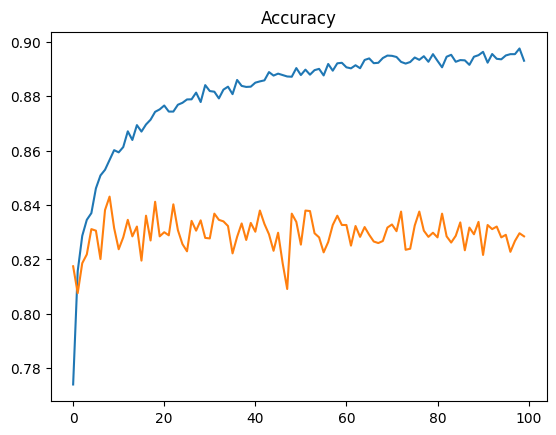

wflc_small_snr2_500_aug10_losses.npy
wflc_small 2


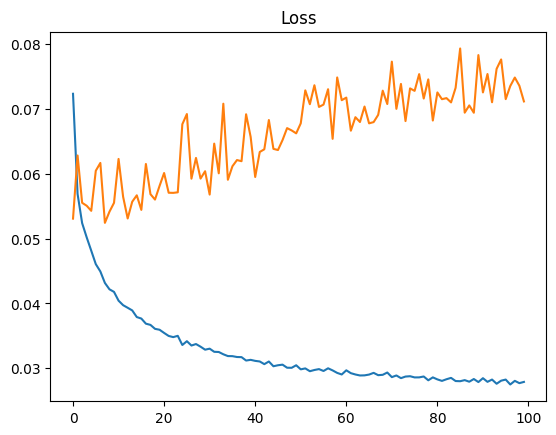

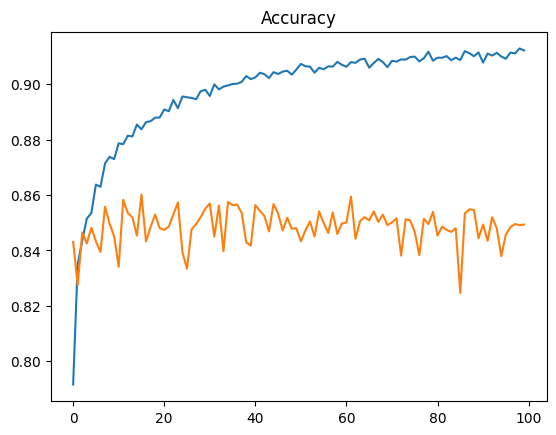

wflc_small_snr5_200_aug10_losses.npy
wflc_small 5


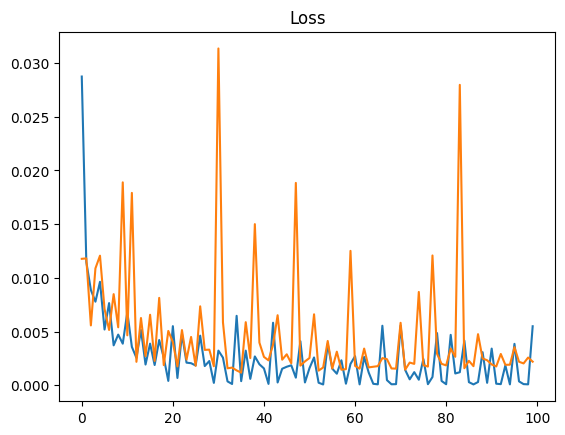

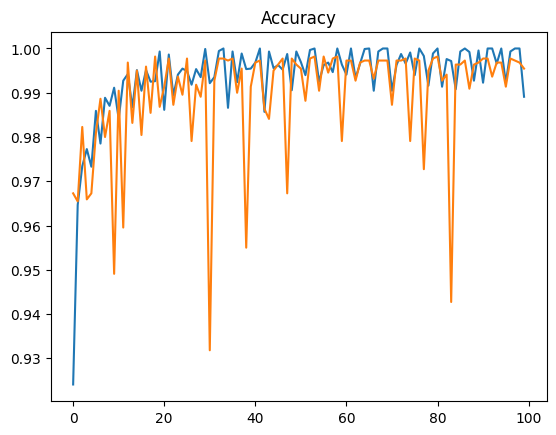

In [3]:
for filename in os.listdir(dir):
    if 'losses' in filename and '.npy' in filename:
        print(filename)
        name_comp = filename.split('_')
        model_name = '_'.join([name_comp[0], name_comp[1]])
        snr = name_comp[2][3:]
        print(model_name, snr)
        
        train_loss, train_acc, val_loss, val_acc = np.load(os.path.join(dir, filename), allow_pickle=True)
        
        plt.plot(train_loss)
        plt.plot(val_loss)
        plt.title('Loss')
        plt.show()
    
        plt.plot(train_acc)
        plt.plot(val_acc)
        plt.title('Accuracy')
        plt.show()

In [4]:
import torch

from models import WhisperForLetterClassification
from configs import WflcConfigs

model_path = 'models/wflc_tiny_snr1_500_aug10_best.npz'

wflc_tiny_config = WflcConfigs.get_config('wflc_tiny')
wflc_tiny = WhisperForLetterClassification(wflc_tiny_config)
wflc_tiny = wflc_tiny.to(device='cuda:0')
wflc_tiny.load_state_dict(torch.load(model_path)['model_state_dict'])

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-tiny and are newly initialized: ['model.classifier.weight', 'model.projector.weight', 'model.projector.bias', 'model.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [5]:
import librosa
import soundfile as sf

# Reads audio from file. Target sample rate can be set to resample audio to match that.
# If audio is stereo, default to using first channel
def read_audio(path, target_sr=None, channel=0):
    audio, sr = librosa.load(path)
    if target_sr is None or sr == target_sr:
        return audio, sr
    else:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        sr = 16000
    return audio, sr

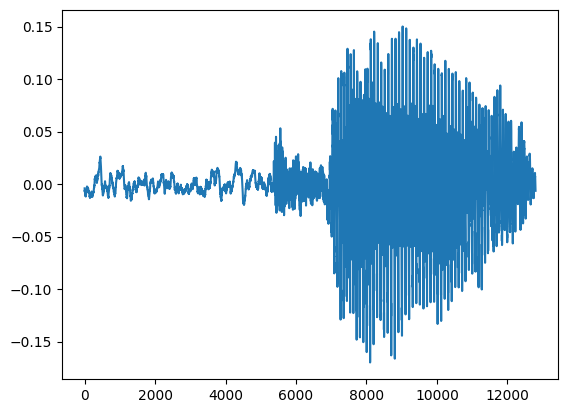

In [6]:

plt.plot(audio)

In [7]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')



In [68]:
# Run model on audio from files.
def inference_file(model, feature_extractor, file_path):
    model.eval()
    audio, sr = read_audio(file_path, 16000)
    
    features = feature_extractor(audio, sampling_rate=sr)['input_features'][0][:400]
    features_tensor = torch.unsqueeze(torch.tensor(features), 0).cuda()

    window_length = 150
    window_shift = 100
    window_start = 0
    window_end = window_length
    reach_end = False

    output_list = []
    while True:
        # If window position exceeds feature shape, flag as last window
        if window_end >= features_tensor.size()[2]:
            window_start = features_tensor.size()[2] - window_length
            window_end = features_tensor.size()[2]
    
            reach_end = True
        
        features_slice = features_tensor[:, :, window_start:window_end]
    
        out = model.forward(features_slice)
        output_list.append(out)
        
        # Update Window Position
        window_start += window_shift
        window_end += window_shift
        
        if reach_end:
            break
    return output_list

def check_correct(output_list, correct_class, default_class=10):
    classifications = set([torch.argmax(x).item() for x in output_list])
    print(classifications, correct_class)
    # Case where nothing is in the audio
    if len(classifications) == 1 and default_class in classifications and correct_class == default_class:
        return 1

    # Case when default and correct class is in the output
    if len(classifications) == 2 and default_class in classifications and correct_class in classifications:
        return 1

    return 0

In [69]:
from tqdm import tqdm
sloan_letters = ['c', 'd', 'h', 'k', 'n', 'o', 'r', 's', 'v', 'z']
local_dataset_path = 'datasets/local_sloans'
alphadigit_dataset_path = 'datasets/alphadigit_sloans'

def test_model(model_path, model_config, feature_extractor, dataset_path, num_samples):
    model = WhisperForLetterClassification(model_config)
    model = model.to(device='cuda:0')
    model.load_state_dict(torch.load(model_path)['model_state_dict'])

    class_corrects = []
    class_num_checks = []
    class_accuracy = []
    for class_id, sloan_letter in enumerate(tqdm(sloan_letters)):
        class_letter_dir = os.path.join(local_dataset_path, sloan_letter)
        
        class_corrects.append(0)
        class_num_checks.append(0)
    
        choosen_files = np.random.choice(list(os.listdir(class_letter_dir)), num_samples)
        
        for filename in choosen_files:
            file_path = os.path.join(class_letter_dir, filename)
    
            out = inference_file(model, feature_extractor, file_path)
            class_corrects[class_id] += check_correct(out, class_id)
            class_num_checks[class_id] += 1
    
        class_accuracy.append((sloan_letter, class_corrects[class_id]/class_num_checks[class_id]))
    return class_accuracy

def parse_model_name(filename):
    parts = filename.split('_')
    model_name = '_'.join((parts[0], parts[1]))
    num_samples = int(parts[3])
    snr = int(parts[2][3:])
    if 'nofreeze' in filename:
        encoder_type = 'nofreeze'
        checkpoint = parts[6].split('.')[0]
    else:
        encoder_type = 'freeze'
        checkpoint = parts[5].split('.')[0]
    return {
        'model_name': model_name,
        'num_samples': num_samples,
        'snr': snr,
        'encoder_type': encoder_type,
        'checkpoint': checkpoint
    }

def get_models(dir):
    model_filenames = []
    for filename in os.listdir(dir):
        if '.npz' in filename and not 'losses' in filename:
            model_filenames.append(filename)
    return model_filenames
    

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')
model_filenames = get_models('models')
benchmarks = []
for model_filename in tqdm(model_filenames, desc='Testing Models'):
    model_properties = parse_model_name(model_filename)
    if model_properties['num_samples'] < 200:
        continue
    print(model_properties)
    model_path = os.path.join('models', model_filename)
    model_config = WflcConfigs.get_config(model_properties['model_name'])
    class_accuracies = test_model(model_path, model_config, feature_extractor, alphadigit_dataset_path, 40)
    print(class_accuracies)

Testing Models:   0%|                                                                            | 0/3 [00:00<?, ?it/s]

{'model_name': 'wflc_tiny', 'num_samples': 500, 'snr': 1, 'encoder_type': 'freeze', 'checkpoint': 'best'}


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-tiny and are newly initialized: ['model.classifier.weight', 'model.projector.weight', 'model.projector.bias', 'model.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

{0, 10} 0
{0, 10} 0
{0, 10} 0
{8, 10} 0
{8, 10} 0
{8, 10} 0
{8, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{8, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{2, 10} 0
{0, 10} 0
{8, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{8, 10} 0
{0, 10} 0
{0, 10} 0
{8, 10} 0
{0, 10} 0
{8, 10} 0
{0, 10} 0
{8, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0
{0, 10} 0



 10%|████████▎                                                                          | 1/10 [00:07<01:08,  7.62s/it]

{2, 10} 0
{1, 10} 1
{8, 1, 10} 1
{1, 10} 1
{10, 4} 1
{1, 10} 1
{1, 10} 1
{1, 10} 1
{8, 10} 1
{8, 10} 1
{0, 10} 1
{10, 4} 1
{1, 10} 1
{1, 10} 1
{8, 10} 1
{1, 10} 1
{1, 10} 1
{1, 10} 1
{1, 10} 1
{0, 10} 1
{1, 10} 1
{8, 10} 1
{1, 10} 1
{8, 1, 10} 1
{1, 10} 1
{1, 10} 1
{1, 10} 1
{1, 10} 1
{8, 10} 1
{8, 10} 1
{8, 10} 1
{1, 10} 1
{1, 10} 1
{8, 10} 1
{8, 10} 1
{1, 10} 1
{8, 10} 1
{8, 10} 1
{10, 3} 1
{8, 10} 1
{1, 10} 1



 20%|████████████████▌                                                                  | 2/10 [00:15<01:00,  7.61s/it]

{8, 10, 3} 2
{8, 2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{0, 2, 10} 2
{2, 10} 2
{2, 10, 6} 2
{8, 2, 10} 2
{2, 10} 2
{2, 10} 2
{8, 2, 10} 2
{2, 10} 2
{8, 2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{0, 2, 10} 2
{2, 10} 2
{8, 2, 10} 2
{10, 3} 2
{8, 10, 3} 2
{8, 2, 10} 2
{2, 10} 2
{9, 2, 10} 2
{8, 2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{2, 10} 2
{8, 2, 10} 2
{2, 10} 2
{0, 10} 2
{2, 10} 2



 30%|████████████████████████▉                                                          | 3/10 [00:23<00:54,  7.72s/it]

{2, 10} 2
{10, 3} 3
{10, 3} 3
{10, 6} 3
{10, 3} 3
{1, 10} 3
{10, 3} 3
{0, 10} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{9, 10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 6} 3
{10, 3} 3
{10, 3} 3
{2, 10} 3
{9, 10} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 6} 3
{10, 3} 3
{10, 6} 3
{10, 3} 3
{9, 10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3
{10, 3} 3



 40%|█████████████████████████████████▏                                                 | 4/10 [00:30<00:46,  7.79s/it]

{10, 4} 4
{10, 4} 4
{10, 4} 4
{10, 4} 4
{10, 4} 4
{10, 6} 4
{10, 4} 4
{10, 4} 4
{10, 4} 4
{1, 10} 4
{10, 6} 4
{10, 6} 4
{10, 6} 4
{10, 4} 4
{10, 4} 4
{1, 10} 4
{8, 10} 4
{10, 4} 4
{10, 4} 4
{10, 4} 4
{10, 6} 4
{10, 4} 4
{10, 6} 4
{10, 4} 4
{10, 6} 4
{10, 6} 4
{10, 7} 4
{10, 5} 4
{10, 4, 5} 4
{10, 4} 4
{10, 6} 4
{10, 6} 4
{10, 6} 4
{10, 4} 4
{10, 6} 4
{10, 4} 4
{10, 6} 4
{10, 7} 4
{10, 4} 4



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:39<00:39,  7.98s/it]

{10, 6} 4
{10, 5} 5
{8, 10} 5
{10, 5} 5
{10, 5, 6} 5
{10, 5, 6} 5
{10, 5} 5
{10, 5} 5
{2, 10, 5} 5
{10, 6} 5
{9, 10} 5
{10, 5} 5
{10, 6} 5
{10, 4} 5
{10, 5} 5
{10, 5} 5
{10, 5} 5
{10, 5} 5
{1, 10} 5
{10, 4} 5
{2, 10} 5
{10, 5} 5
{10, 5} 5
{8, 10} 5
{2, 10} 5
{8, 10} 5
{10, 5} 5
{10, 6} 5
{10, 5} 5
{9, 10} 5
{10, 5} 5
{10, 5} 5
{8, 10} 5
{10, 4} 5
{9, 10} 5
{10, 5} 5
{10, 5} 5
{10, 6} 5
{10, 5} 5
{10, 4} 5
{2, 10} 5



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:48<00:33,  8.33s/it]

{10, 6} 6
{10, 5} 6
{10, 6} 6
{10, 6} 6
{10, 5} 6
{10, 6} 6
{10, 7} 6
{10, 6} 6
{10, 6} 6
{10, 7} 6
{10, 5} 6
{10, 7} 6
{10, 4} 6
{10, 6} 6
{10, 5} 6
{10, 6} 6
{8, 10} 6
{8, 10, 6} 6
{10, 5} 6
{10, 5} 6
{10, 6} 6
{10, 5} 6
{10, 4} 6
{10, 5} 6
{10, 6} 6
{10, 6} 6
{10, 6} 6
{10, 6} 6
{10, 5} 6
{10, 5} 6
{10, 5, 6} 6
{10, 6} 6
{10, 6} 6
{10, 6} 6
{10, 7} 6
{10, 6} 6
{10, 5} 6
{10, 6} 6
{10, 6} 6



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:57<00:25,  8.50s/it]

{10, 6} 6
{10, 7} 7
{8, 10, 7} 7
{10, 7} 7
{10, 4} 7
{8, 10} 7
{10, 7} 7
{10, 4} 7
{10, 7} 7
{10, 7} 7
{1, 10, 7} 7
{10, 7} 7
{10, 7} 7
{10, 4} 7
{2, 10, 4} 7
{10, 7} 7
{10, 6} 7
{10, 3, 7} 7
{10, 7} 7
{10, 7} 7
{10, 6} 7
{10, 7} 7
{8, 10} 7
{0, 10} 7
{10, 7} 7
{10, 7} 7
{10, 7} 7
{10, 7} 7
{10, 7} 7
{10, 7} 7
{10, 7} 7
{10, 7} 7
{0, 10} 7
{8, 10, 7} 7
{10, 7} 7
{10, 7} 7
{1, 10, 7} 7
{9, 10, 7} 7
{10, 4} 7
{10, 4} 7



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:05<00:17,  8.59s/it]

{10, 7} 7
{8, 10} 8
{10, 4} 8
{8, 10} 8
{8, 10} 8
